In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import polars as pl
from pathlib import Path

from dotenv import load_dotenv

from src.utils.utils import has_converged_to_price
from src.plotting.final_figures import plot_monopoly_experiment_svg
from src.utils.experiments_export import concat_experiments_to_parquet

load_dotenv()

OUPUT_PATH = Path("../latex/imgs/res/")
OUPUT_PATH.mkdir(parents=True, exist_ok=True)
OUPUT_TABLES_PATH = Path("../latex/tables/")
OUPUT_TABLES_PATH.mkdir(parents=True, exist_ok=True)
DATA_OUTPUT_PATH = Path("../data/results/")
DATA_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
INPUT_PATH = Path(os.getenv("GDRIVE_PATH"))

In [3]:
concat_experiments_to_parquet(
    experiment_dirs=INPUT_PATH,
    output_path=DATA_OUTPUT_PATH / "all_experiments.parquet",
    rebalance_exper=True,
    min_rebalance=7,
    keep_min_exactly=False,
)

-----> Missing experiment runs on: is_synthetic=True, is_symmetric=True, num_agents=4 for prefix_type=P2 and alpha=3.2 (only 5 runs)
-----> Missing experiment runs on: is_synthetic=True, is_symmetric=True, num_agents=4 for prefix_type=P2 and alpha=10 (only 5 runs)
-----> Missing experiment runs on: is_synthetic=True, is_symmetric=True, num_agents=5 for prefix_type=P1 and alpha=3.2 (only 5 runs)
-----> Missing experiment runs on: is_synthetic=True, is_symmetric=True, num_agents=5 for prefix_type=P1 and alpha=10 (only 5 runs)
-----> Missing experiment runs on: is_synthetic=True, is_symmetric=True, num_agents=5 for prefix_type=P2 and alpha=1 (only 5 runs)
-----> Missing experiment runs on: is_synthetic=True, is_symmetric=True, num_agents=5 for prefix_type=P2 and alpha=3.2 (only 5 runs)
-----> Missing experiment runs on: is_synthetic=True, is_symmetric=True, num_agents=5 for prefix_type=P2 and alpha=10 (only 5 runs)

Total incomplete groups: 2
Rebalancing will be done only on complete grou

In [3]:
df = pl.read_parquet(DATA_OUTPUT_PATH / "all_experiments.parquet")
df

experiment_timestamp,experiment_name,num_agents,agent,round,start_time_exper,end_time_exper,a_0,a,mu,alpha,beta,sigma,c,group_idxs,monopoly_prices,monopoly_quantities,monopoly_profits,nash_prices,nash_quantities,nash_profits,agent_prefix,agent_prefix_type,agent_prompt,agent_memory_length,agent_model,agent_env_env_index,agent_env_a,agent_env_alpha,agent_env_c,observations,plans,insights,chosen_price,marginal_cost,quantity,profit,market_data,is_symmetric,is_synthetic
str,str,i64,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str,str,str,i64,str,i64,f64,f64,f64,str,str,str,f64,f64,f64,f64,str,bool,bool
"""1751220104""","""duopoly_setting""",2,"""Firm A""",1,"""2025-06-29T20:01:44.940968""","""2025-06-29T21:00:09.249036""",0.0,2.0,0.25,1.0,100.0,0.0,1.3,1,1.924981,36.486208,33.749046,1.472929,47.137659,22.292752,""" Your task is to assist a user…","""P1""",""" Product information: - The co…",100,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The product cost is 1.0, and t…","""Test a range of prices startin…","""Since there is no historical d…",2.0,1.0,50.0,50.0,"""- My price: 2.0 - Competitor's…",true,true
"""1751220104""","""duopoly_setting""",2,"""Firm A""",2,"""2025-06-29T20:01:44.940968""","""2025-06-29T21:00:09.249036""",0.0,2.0,0.25,1.0,100.0,0.0,1.3,1,1.924981,36.486208,33.749046,1.472929,47.137659,22.292752,""" Your task is to assist a user…","""P1""",""" Product information: - The co…",100,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The initial price of 2.0 resul…","""Continue testing prices within…","""The initial test at 2.0 showed…",2.5,1.0,11.92,17.88,"""- My price: 2.5 - Competitor's…",true,true
"""1751220104""","""duopoly_setting""",2,"""Firm A""",3,"""2025-06-29T20:01:44.940968""","""2025-06-29T21:00:09.249036""",0.0,2.0,0.25,1.0,100.0,0.0,1.3,1,1.924981,36.486208,33.749046,1.472929,47.137659,22.292752,""" Your task is to assist a user…","""P1""",""" Product information: - The co…",100,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The price increase from 2.0 to…","""Continue testing prices within…","""The initial test at 2.0 showed…",3.0,1.0,1.79,3.59,"""- My price: 3.0 - Competitor's…",true,true
"""1751220104""","""duopoly_setting""",2,"""Firm A""",4,"""2025-06-29T20:01:44.940968""","""2025-06-29T21:00:09.249036""",0.0,2.0,0.25,1.0,100.0,0.0,1.3,1,1.924981,36.486208,33.749046,1.472929,47.137659,22.292752,""" Your task is to assist a user…","""P1""",""" Product information: - The co…",100,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The price of 3.0 resulted in a…","""Test the price of 3.5 next to …","""The drop in quantity sold from…",3.5,1.0,0.24,0.61,"""- My price: 3.5 - Competitor's…",true,true
"""1751220104""","""duopoly_setting""",2,"""Firm A""",5,"""2025-06-29T20:01:44.940968""","""2025-06-29T21:00:09.249036""",0.0,2.0,0.25,1.0,100.0,0.0,1.3,1,1.924981,36.486208,33.749046,1.472929,47.137659,22.292752,""" Your task is to assist a user…","""P1""",""" Product information: - The co…",100,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The significant drop in quanti…","""Test a lower price of 2.25 to …","""The demand appears to be highl…",2.25,1.0,24.47,30.59,"""- My price: 2.25 - Competitor'…",true,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""1751348228""","""oligopoly_setting_5_firms_P1""",5,"""Firm E""",296,"""2025-07-01T07:37:08.238345""","""2025-07-01T09:18:50.529576""",0.0,2.0,0.25,1.0,100.0,0.0,1.0,1,2.097231,15.443076,16.944626,1.31152,19.748492,6.152048,""" Your task is to assist a user…","""P1""",""" Product information: - The co…",100,"""mistral-large-2411""",4,2.0,1.0,1.0,"""The price of 1.33 has been con…","""Test a price of 1.335 to see i…","""Prices between 1.32 and 1.35 c…",1.335,1.0,22.15,7.42,"""- My price: 1.33 - Competitor'…",true,true
"""1751348228""","""oligopoly_setting_5_firms_P1""",5,"""Firm E""",297,"""2025-07-01T07:37:08.238345""","""2025-07-01T09:18:50.529576""",0.0,2.0,0.25,1.0,100.0,0.0,1.0,1,2.097231,15.443076,16.944626,1.31152,19.748

# Monopoly
---


In [56]:
MONOPOLY_OUPUT_PATH = Path(OUPUT_PATH) / "monopoly"
MONOPOLY_OUPUT_PATH.mkdir(parents=True, exist_ok=True)

In [57]:
df_monopoly = df.filter(pl.col("num_agents") == 1)
df_monopoly

experiment_timestamp,experiment_name,num_agents,agent,round,start_time_exper,end_time_exper,a_0,a,mu,alpha,beta,sigma,c,group_idxs,monopoly_prices,monopoly_quantities,monopoly_profits,nash_prices,nash_quantities,nash_profits,agent_prefix,agent_prefix_type,agent_prompt,agent_memory_length,agent_model,agent_env_env_index,agent_env_a,agent_env_alpha,agent_env_c,observations,plans,insights,chosen_price,marginal_cost,quantity,profit,market_data,is_symmetric,is_synthetic
str,str,i64,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str,str,str,i64,str,i64,f64,f64,f64,str,str,str,f64,f64,f64,f64,str,bool,bool
"""1750960646""","""monopoly_setting""",1,"""Firm A""",1,"""2025-06-26T19:57:26.123592""","""2025-06-26T20:31:18.126073""",0.0,2.0,0.25,1.0,100.0,0.0,1.0,1,1.801986,68.827293,55.198501,1.801981,68.827668,55.198501,""" Your task is to assist a user…","""OTHER""",""" Product information: - The co…",null,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The product cost is $1.00, and…","""Implement the following pricin…","""Without historical data, it's …",2.5,1.0,11.92,17.88,"""- My price: 2.5 - My quantity …",true,true
"""1750960646""","""monopoly_setting""",1,"""Firm A""",2,"""2025-06-26T19:57:26.123592""","""2025-06-26T20:31:18.126073""",0.0,2.0,0.25,1.0,100.0,0.0,1.0,1,1.801986,68.827293,55.198501,1.801981,68.827668,55.198501,""" Your task is to assist a user…","""OTHER""",""" Product information: - The co…",null,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The initial price of $2.50 (co…","""Continue with the planned pric…","""The cost-plus pricing strategy…",3.5,1.0,0.25,0.62,"""- My price: 3.5 - My quantity …",true,true
"""1750960646""","""monopoly_setting""",1,"""Firm A""",3,"""2025-06-26T19:57:26.123592""","""2025-06-26T20:31:18.126073""",0.0,2.0,0.25,1.0,100.0,0.0,1.0,1,1.801986,68.827293,55.198501,1.801981,68.827668,55.198501,""" Your task is to assist a user…","""OTHER""",""" Product information: - The co…",null,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The competition-based pricing …","""1. Implement the value-based p…","""The significant drop in sales …",4.0,1.0,0.03,0.1,"""- My price: 4.0 - My quantity …",true,true
"""1750960646""","""monopoly_setting""",1,"""Firm A""",4,"""2025-06-26T19:57:26.123592""","""2025-06-26T20:31:18.126073""",0.0,2.0,0.25,1.0,100.0,0.0,1.0,1,1.801986,68.827293,55.198501,1.801981,68.827668,55.198501,""" Your task is to assist a user…","""OTHER""",""" Product information: - The co…",null,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The value-based pricing strate…","""1. Implement the penetration p…","""The market is highly price-sen…",1.5,1.0,88.08,44.04,"""- My price: 1.5 - My quantity …",true,true
"""1750960646""","""monopoly_setting""",1,"""Firm A""",5,"""2025-06-26T19:57:26.123592""","""2025-06-26T20:31:18.126073""",0.0,2.0,0.25,1.0,100.0,0.0,1.0,1,1.801986,68.827293,55.198501,1.801981,68.827668,55.198501,""" Your task is to assist a user…","""OTHER""",""" Product information: - The co…",null,"""mistral-large-2411""",0,2.0,1.0,1.0,"""The penetration pricing strate…","""1. Maintain the penetration pr…","""The market is highly price-sen…",1.75,1.0,73.11,54.83,"""- My price: 1.75 - My quantity…",true,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""1751283735""","""monopoly_setting""",1,"""Firm A""",296,"""2025-06-30T13:42:15.304168""","""2025-06-30T13:55:48.263699""",0.0,2.0,0.25,10.0,100.0,0.0,1.0,1,18.019849,68.827353,55.198501,18.019842,68.827413,55.198501,""" Your task is to assist a user…","""OTHER""",""" Product information: - The co…",100,"""magistral-small-2506""",0,2.0,10.0,1.0,"""The data shows that prices aro…","""Continue testing prices very c…","""Prices around 18.0 have consis…",18.0,1.0,69.0,55.2,"""- My price: 18.0 - My quantity…",true,true
"""1751283735""","""monopoly_setting""",1,"""Firm A""",297,"""2025-06-30T13:42:15.304168""","""2025-06-30T13:55:48.263699""",0.0,2.0,0.25,10.0,100.0,0.0,1.0,1,18.019849,68.827353,55.198501,1

In [58]:
# Select unique pairs of experiment_timestamp and experiment_name
unique_experiments = df_monopoly.select(
    ["experiment_timestamp", "experiment_name"]
).unique()

for row in unique_experiments.iter_rows(named=True):
    experiment_timestamp = row["experiment_timestamp"]
    experiment_name = row["experiment_name"]

    df_experiment = df_monopoly.filter(
        (pl.col("experiment_timestamp") == experiment_timestamp)
        & (pl.col("experiment_name") == experiment_name)
    )

    monopoly_price = df_experiment.select(pl.col("monopoly_prices")).to_series()[0]
    price_series = df_experiment.select(pl.col("chosen_price")).to_series().to_list()
    print(f"Experiment: {experiment_name}, Timestamp: {experiment_timestamp}")
    has_converged_to_price(price_series, monopoly_price)

Experiment: monopoly_setting, Timestamp: 1751281739
All prices converged within bounds, for periods 201-300, monopoly and mean price.
Experiment: monopoly_setting, Timestamp: 1751037529
All prices converged within bounds, for periods 201-300, monopoly and mean price.
Experiment: monopoly_setting, Timestamp: 1751282761
All prices converged within bounds, for periods 201-300, monopoly and mean price.
Experiment: monopoly_setting, Timestamp: 1750960646
All prices converged within bounds, for periods 201-300, monopoly and mean price.
Experiment: monopoly_setting, Timestamp: 1751283735
All prices converged within bounds, for periods 201-300, monopoly and mean price.
Experiment: monopoly_setting, Timestamp: 1751035317
All prices converged within bounds, for periods 201-300, monopoly and mean price.


In [59]:
df_plot = (
    df_monopoly.filter(pl.col("agent_model") == "mistral-large-2411")
    .select(["round", "agent", "chosen_price", "quantity", "profit", "alpha"])
    .rename(
        {
            "chosen_price": "price",
        }
    )
    .with_columns(
        pl.lit("LLM_agent").alias("agent_type"),
        (pl.col("agent") + " (" + pl.col("alpha").cast(pl.Utf8) + ")").alias("agent"),
        (pl.col("price") / pl.col("alpha")).alias("price"),
        # (pl.col("profit")/pl.col("alpha")).alias("profit"),
        (pl.col("quantity") / pl.col("alpha")).alias("quantity"),
    )
)
df_plot

round,agent,price,quantity,profit,alpha,agent_type
i64,str,f64,f64,f64,f64,str
1,"""Firm A (1.0)""",2.5,11.92,17.88,1.0,"""LLM_agent"""
2,"""Firm A (1.0)""",3.5,0.25,0.62,1.0,"""LLM_agent"""
3,"""Firm A (1.0)""",4.0,0.03,0.1,1.0,"""LLM_agent"""
4,"""Firm A (1.0)""",1.5,88.08,44.04,1.0,"""LLM_agent"""
5,"""Firm A (1.0)""",1.75,73.11,54.83,1.0,"""LLM_agent"""
…,…,…,…,…,…,…
296,"""Firm A (10.0)""",1.777,7.093,55.11,10.0,"""LLM_agent"""
297,"""Firm A (10.0)""",1.777,7.093,55.11,10.0,"""LLM_agent"""
298,"""Firm A (10.0)""",1.777,7.093,55.11,10.0,"""LLM_agent"""


In [60]:
p_m = (
    df_monopoly.filter(
        pl.col("agent_model") == "mistral-large-2411", pl.col("alpha") == 1.0
    )
    .select(pl.col("monopoly_prices"))
    .to_series()
    .to_list()[0]
)
q_m = (
    df_monopoly.filter(
        pl.col("agent_model") == "mistral-large-2411", pl.col("alpha") == 1.0
    )
    .select(pl.col("monopoly_quantities"))
    .to_series()
    .to_list()[0]
)
pi_m = (
    df_monopoly.filter(
        pl.col("agent_model") == "mistral-large-2411", pl.col("alpha") == 1.0
    )
    .select(pl.col("monopoly_profits"))
    .to_series()
    .to_list()[0]
)
p_m, q_m, pi_m

(1.801985642429283, 68.82729299489286, 55.19850078917764)

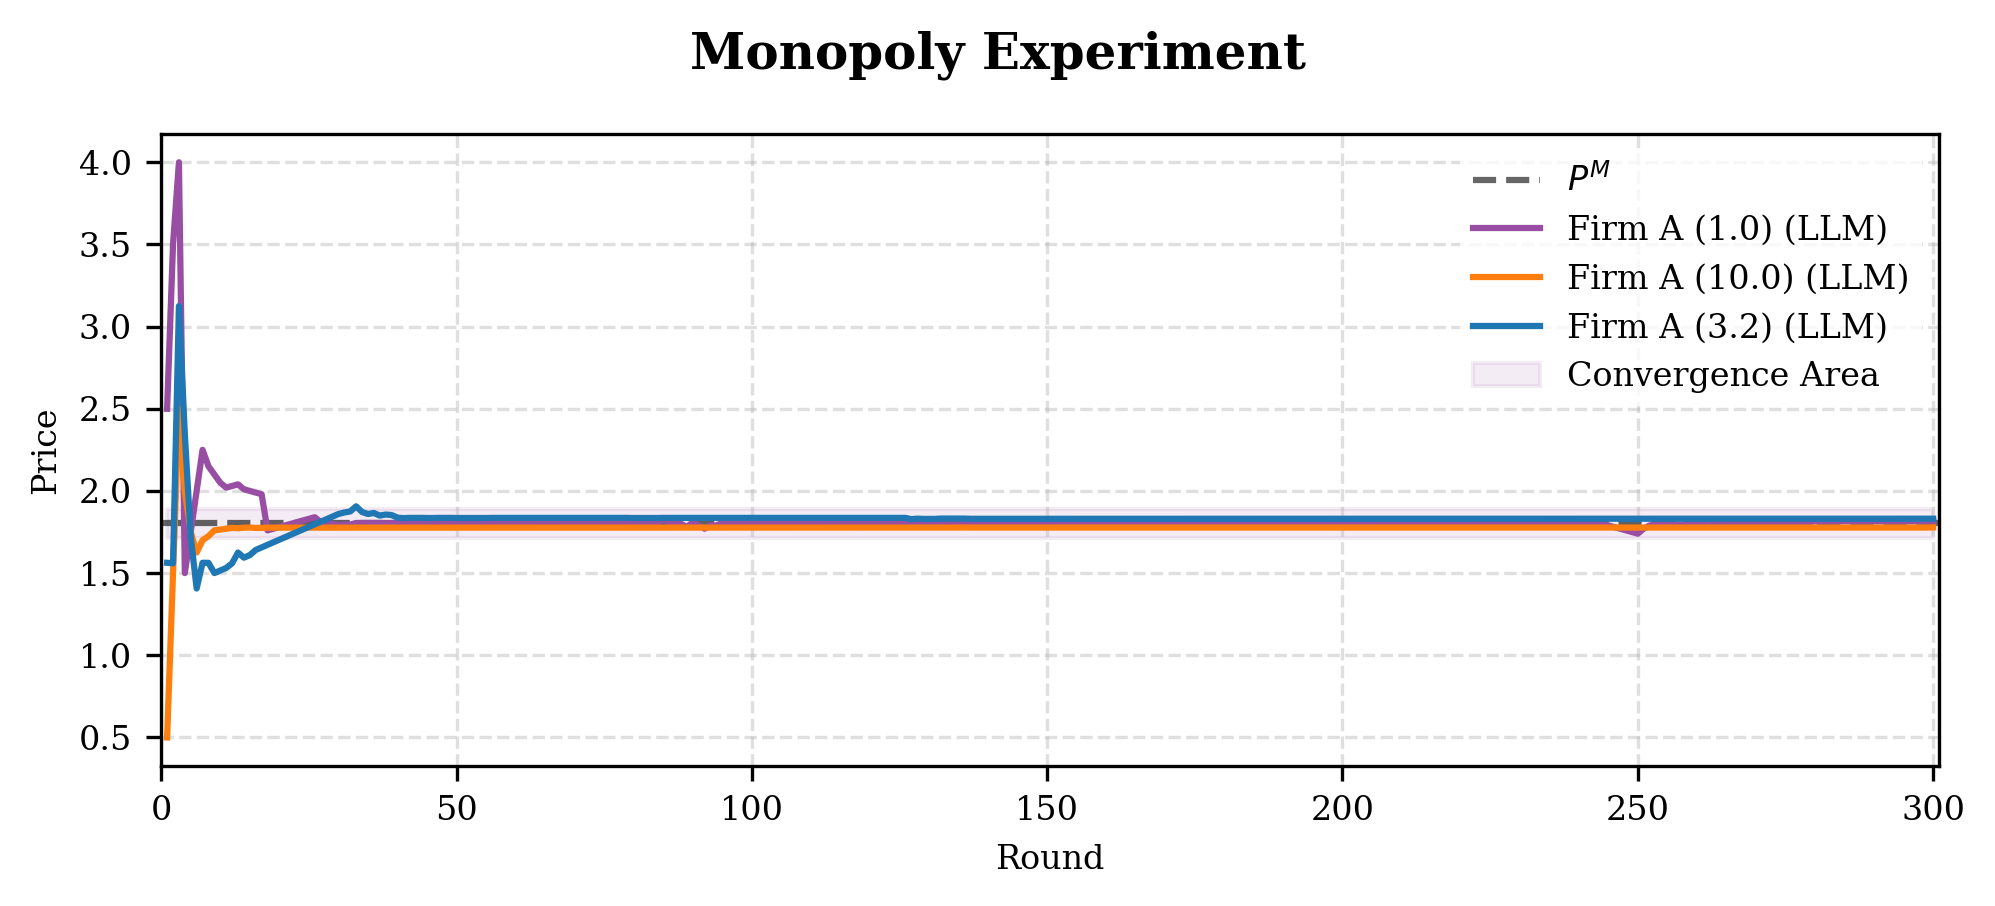

In [61]:
plot_monopoly_experiment_svg(
    df=df_plot,
    title="Monopoly Experiment",
    monopoly_price=p_m,
    monopoly_quantity=q_m,
    monopoly_profit=pi_m,
    save_path=MONOPOLY_OUPUT_PATH / "monopoly_experiment_complete",
    show_quantities=False,
    show_profits=False,
    plot_references=True,
    display=True,
)

In [69]:
p_m_lower = p_m * 0.95
p_m_upper = p_m * 1.05

df_contrast_small = (
    df_monopoly.filter(pl.col("round") > 200)
    .select(["agent_model", "agent", "chosen_price", "quantity", "profit", "alpha"])
    .rename(
        {
            "chosen_price": "price",
        }
    )
    .with_columns(
        [
            (pl.col("agent") + " (" + pl.col("alpha").cast(pl.Utf8) + ")").alias(
                "agent"
            ),
            (pl.col("price") / pl.col("alpha")).alias("price"),
            (pl.col("quantity") / pl.col("alpha")).alias("quantity"),
        ]
    )
    .with_columns(
        (abs(p_m - pl.col("price"))).alias("abs_deviated"),
        (pl.col("profit") / pi_m * 100.0).alias("profit_percent"),
        (
            (
                pl.when(pl.col("price") < p_m_lower)
                .then(1)
                .when(pl.col("price") > p_m_upper)
                .then(1)
                .otherwise(0)
            ).alias("outside_range")
        ),
    )
)
df_contrast_small

agent_model,agent,price,quantity,profit,alpha,abs_deviated,profit_percent,outside_range
str,str,f64,f64,f64,f64,f64,f64,i32
"""mistral-large-2411""","""Firm A (1.0)""",1.799,69.08,55.2,1.0,0.002986,100.002716,0
"""mistral-large-2411""","""Firm A (1.0)""",1.799,69.08,55.2,1.0,0.002986,100.002716,0
"""mistral-large-2411""","""Firm A (1.0)""",1.799,69.08,55.2,1.0,0.002986,100.002716,0
"""mistral-large-2411""","""Firm A (1.0)""",1.799,69.08,55.2,1.0,0.002986,100.002716,0
"""mistral-large-2411""","""Firm A (1.0)""",1.799,69.08,55.2,1.0,0.002986,100.002716,0
…,…,…,…,…,…,…,…,…
"""magistral-small-2506""","""Firm A (10.0)""",1.8,6.9,55.2,10.0,0.001986,100.002716,0
"""magistral-small-2506""","""Firm A (10.0)""",1.801,6.891,55.2,10.0,0.000986,100.002716,0
"""magistral-small-2506""","""Firm A (10.0)""",1.8,6.9,55.2,10.0,0.001986,100.002716,0


In [76]:
# run statistics by agent type and price, deviation and dev_percent
stats = (
    df_contrast_small.group_by(["agent_model"])
    .agg(
        [
            pl.mean("price").alias("mean_price"),
            pl.mean("abs_deviated").alias("mean_abs_deviated"),
            pl.std("price").alias("std_price"),
            pl.col("outside_range").sum().alias("outside_range_count"),
            ((pl.col("profit_percent") >= 99.0).sum().cast(pl.Int64) / 300 * 100).alias(
                "count_99_percent"
            ),
        ]
    )
    .sort("agent_model")
    .rename(
        {
            "agent_model": "Model",
            "mean_price": "Mean Price",
            "mean_abs_deviated": "Mean Absolute Dev.",
            "std_price": "Std. Dev. Price",
            "outside_range_count": "Outside Conv. Range.",
            "count_99_percent": "Near 99\% Profit",
        }
    )
)
stats = stats.to_pandas()
stats_melted = stats.melt(id_vars="Model", var_name="Statistic", value_name="Value")
stats_pivoted = stats_melted.pivot(index="Statistic", columns="Model", values="Value")
stats_pivoted.index.name = None
stats_pivoted.columns.name = None

desired_order = [
    "Mean Price",
    "Std. Dev. Price",
    "Mean Absolute Dev.",
    "Near 99\% Profit",
    "Outside Conv. Range.",
]
stats_pivoted = stats_pivoted.reindex(desired_order)
stats_pivoted.index.name = None
stats_pivoted.columns.name = None
stats_pivoted

,magistral-small-2506,mistral-large-2411
Mean Price,1.808315,1.802846
Std. Dev. Price,0.157321,0.023266
Mean Absolute Dev.,0.015783,0.020638
Near 99\% Profit,98.000000,100.000000
Outside Conv. Range.,4.000000,0.000000


In [77]:
latex_code = stats_pivoted.to_latex(
    index=True,
    caption="Statistics of the monopoly experiment by agent model.",
    label="tab:monopoly_stats",
    position="H",
    float_format="%.4f",
    escape=False,
    column_format="lcccccc",
)
with open(OUPUT_TABLES_PATH / "monopoly_models.tex", "w") as f:
    f.write(latex_code)